In [5]:
# imports

# Foursquare

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

### Step 1: Establish broad API call
* ensures API ok


In [ ]:
import json

import requests
import os

FS_API_KEY = os.getenv('FOURSQUARE_API_KEY')


print(FS_API_KEY)

location = "Vancouver, Canada"
url = "https://api.foursquare.com/v3/places/search?near=" + location

# Create dictionary for headers

payload = {}
headers = {
        "Accept": "application/json",
        'Authorization': FS_API_KEY
            }

response = requests.request("GET", url, headers=headers, data=payload)

print(response.json())

## Step 2: Prepare and Test Lat Long info from SQL
* ensure syntax is correct
* update Postgres DB to avoid potential concatenation complication in code.
* 

In [7]:
## SQL to create a new column in the City_bike Table. 
# Performed in Postgres

'''UPDATE city_bikes
SET lat_long = (select concat(latitude,',',longitude));'''



"UPDATE city_bikes\nSET lat_long = (select concat(latitude,',',longitude));"

## Step 3: Create DataFrame of Lat/Long and iterate to create API calls

In [8]:
import pandas as pd

data = pd.read_csv('../data/city_bikes.csv')
vancouver_stations = pd.DataFrame(data)
# vancouver_stations_TEST= vancouver_stations.head(2)
# vancouver_stations_TEST
vancouver_stations

,empty_slots,free_bikes,id,latitude,longitude,name,timestamp,extra_ebikes,extra_has_ebikes,extra_last_updated,lat_long
0,5,29,7a19c49f486d7c0c02b3685d7b240448,49.262487,-123.114397,10th & Cambie,2023-09-21 19:03:51.469000,6,True,1695322925,"49.262487,-123.114397"
1,12,4,32603a87cfca71d0f7dfa3513bad69d5,49.274566,-123.121817,Yaletown-Roundhouse Station,2023-09-21 19:03:51.456000,0,True,1695322945,"49.274566,-123.121817"
2,13,13,6d42fa40360f9a6b2bf641c7b8bb2862,49.279764,-123.110154,Dunsmuir & Beatty,2023-09-21 19:03:51.457000,1,True,1695322662,"49.279764,-123.110154"
3,11,5,66f873d641d448bd1572ab086665a458,49.260599,-123.113504,12th & Yukon (City Hall),2023-09-21 19:03:51.458000,4,True,1695322780,"49.260599,-123.113504"
4,9,7,485d4d24c803cfde829ab89699fed833,49.264215,-123.117772,8th & Ash,2023-09-21 19:03:51.477000,4,True,1695322949,"49.264215,-123.117772"
...,...,...,...,...,...,...,...,...,...,...,...
240,34,6,a74744ce4bb7ea2aa9f406ac8bff95d8,49.280977,-123.035969,PNE - Hastings & Windermere,2023-09-21 19:03:51.275000,2,True,1695322761,"49.280977,-123.035969"
241,8,11,5699b40126e10c2f68eefc3eb18ff3a1,49.270783,-123.141564,1st & Fir,2023-09-21 19:03:51.247000,1,True,1695322960,"49.270783,-123.141564"
242,15,7,34fd37d12eb989b49518ef53941ee3ff,49.264019,-123.209176,Sasamat & 10th,2023-09-21 19:03:51.199000,3,True,1695322610,"49.264019,-123.209176"
243,18,2,b7dd37a7dd668d6d10024b7f18acc438,49.265800,-123.205960,Trimble & 8th,2023-09-21 19:03:51.246000,1,True,1695322940,"49.2658,-123.20596"


## Foursquare API and Dataframe
### Code Overview (foursquare) 
* function takes lat and long and radius as arguments. 
* GET parameters include desired categories, and field information
* API response (json) file is iterated to retrieve data (name, popularity, price etc)
* data (dictionary) is appended to a list callled "FS_API_result"
* List of lat/longs from CityBikes (vancouver_stations) is itererated.
* Each lat/log in Vancouver_stations creates a new API call in the 'foursquare' function. 
* Results from each call (FS_API_Result) are in turn iterated and appended to the "All Results" list. 
* All_Results is a tidy dictionary that does not require json normalization. 
* DataFrame is created using All_Results dictionary. 
* DataFrame is dumped to json in ../data folder for future reference. 


In [9]:
import requests
import os
from pprint import  pprint

FS_API_KEY = os.getenv('FOURSQUARE_API_KEY')
def foursquare(latitude, longitude, radius):
    ## Initialize an empty list to store the results
    FS_API_Result = []
    
    url = 'https://api.foursquare.com/v3/places/search'
    category_filter = "11062,13003,13004,13005,13006,13007,13008,13009,13010,13011,13012,13013,13014,13015,13016,13017,13018,13019,13020,13021,13022,13023,13024,13025,13059"
    params = { "ll": f"{latitude},{longitude}", "radius": radius, "categories": {category_filter},'fields': 'name,popularity,rating,price,distance,fsq_id'}
    headers = { "Accept": "application/json", "Authorization": FS_API_KEY }
    response = requests.get(url, params=params, headers=headers)
    
    if response.status_code != 200:
        return f"Error: {response.status_code}"
    else:
        data = response.json()
        for i in data['results']:
            details = {
            'name': i.get('name', None),
            'popularity': i.get('popularity', None),
            'rating': i.get('rating', None),
            'price': i.get('price', None),
            'distance': i.get('distance', None),
            'fsq_id': i.get('fsq_id', None)
            }
            FS_API_Result.append(details)
        return FS_API_Result

all_results_FS = []  # Initialize empty list to accumulate results from each API call.
    ## Loop latitude,longitude from station to get details
for index, row in vancouver_stations.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    station_id = row['id']
    result_list = foursquare(latitude, longitude, 1000)

    for result in result_list:
        # Create a new dictionary with latitude and longitude, id of station, then update it with the result dictionary
        combined_result = {'latitude': latitude, 'longitude': longitude, 'station_id': station_id}
        combined_result.update(result)
        
        ## Append the combined dictionary to 'all_results'
        all_results_FS.append(combined_result)
pprint(all_results_FS)

KeyboardInterrupt: 

In [ ]:
pprint(all_results_FS,indent=4)

## Convert the 'all_results' list of dictionaries to a DataFrame

In [ ]:
# pretty = json.dumps(all_results_FS.json(),indent =4)
# print(pretty)

df_foursquare = pd.DataFrame(all_results_FS)


In [ ]:
# Filter DataFrame based on unique records in 'name'
df_unique_locations = df_foursquare[['name','rating','fsq_id']].drop_duplicates(subset='name', keep='first').sort_values(by='rating', ascending=False).reset_index()

# Return only the Top 10
Top10_locations_FS = df_unique_locations.head(10)

Top10_locations_FS



In [ ]:
## SAVE A BACKUP of MY PRECIOUS JSON FILE

import json

with open('../data/FourSquare_APIresult2_data.json', 'w') as f:
    f.write(json.dumps(json.loads(df_foursquare.to_json(orient='records')), indent=4))


In [ ]:
## Create a df subset for testing when merging data later. 
df_FS_TESTING= df_foursquare.head(100)
df_FS_TESTING

# Yelp

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [ ]:
import YELP as creds
import requests
import os
API_KEY=creds.YELP_API
# print(API_KEY) ## Confirmed - API Key ok!! 

def yelp_API_call(latitude, longitude):
    radius =1000
    Yelp_API_Result= []
    
    parameters = {
        "latitude": latitude,
        "longitude": longitude,
        "radius": radius,
        "categories":"bars%2Crestaurants",
        "limit": 50
    }
    url = "https://api.yelp.com/v3/businesses/search"

    headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {API_KEY}" 
    }

    response = requests.get(url, params=parameters, headers=headers)
    # print(response.text)
    ###### Single API Call generated ^^
    
    #### Loop through result to extract target data and populate the Result List
    
    if response.status_code != 200:
        return f"Error: {response.status_code}"
    else:
        data = response.json()
        # print(data)
    
        for i in data['businesses']:
            details = {
            'name': i.get('name', None),
            'review_count':i.get('review_count',None),
            'rating': i.get('rating', None),
            'price': i.get('price', None),
            'distance': i.get('distance', None),
            'id': i.get('id', None)
        }
            Yelp_API_Result.append(details)
        # print(Yelp_API_Result)
        return Yelp_API_Result

#################   
   
    
all_results = []  # Initialize empty list to accumulate results from each API call.

## Loop latitude,longitude from station to get details
for index, row in vancouver_stations.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    station_id = row['id']
    result_list = yelp_API_call(latitude, longitude)
    # all_results.append(result_list)   

    
    for result in result_list:
            # Create a new dictionary with latitude and longitude, id of station, then update it with the result dictionary
            combined_result = {'latitude': latitude, 'longitude': longitude, 'station_id': station_id}
            combined_result.update(result)
            
        ## Append the combined dictionary to 'all_results'
            all_results.append(combined_result)
    print("This is all results:")
    print(all_results)    
    
    



Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [ ]:
import pandas as pd

df_yelp = pd.DataFrame(all_results)
df_yelp.sort_values(by=['rating'], ascending=True)


Put your parsed results into a DataFrame

In [ ]:
# Filter DataFrame based on unique records in 'name'
df_unique_locations = df_yelp[['name','rating','id']].drop_duplicates(subset='name', keep='first').sort_values(by='rating', ascending=False).reset_index()

# Return only the Top 10
Top10_locations_Yelp = df_unique_locations.head(10)

Top10_locations_Yelp

In [ ]:
## Create a df subset for testing when merging data later. 
df_yelp_TESTING= df_yelp.head(100)
df_yelp_TESTING

# Comparing Results

Which API provided you with more complete data? Provide an explanation.
* the Yelp API data provided considerably more data both in terms of results volume and depth of information.  
* For the same inputs (245 stations). FS Yielded ~1,400 unique POI, where as Yelp provided far fewer, 


| FourSquare                                                                                                                                    | YELP                                                                                                                             |
|-----------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------|
| ![FourSquare coverage](../images/FS_initial_coverage_review.png) | ![YelpCoverage](../images/Yelp_initial_coverage_review.png) |


Get the top 10 restaurants according to their rating:
### Top 10
> **Foursquare** 
> ![Foursquare Top10](../images/Top10_Foursquare.png) 

> **Yelp** 
> ![Yelp Top10](../images/Top10_Yelp.png)

## Comparing API Quality (continued)

In [ ]:
import pandas as pd

## Import .csv from API calls
STATIONS= pd.read_csv('../data/city_bikes.csv')
YELP = pd.read_csv('../data/Yelp_location_results.csv')
FS = pd.read_csv('../data/FS_location_results.csv')

YELP['lat_long']=YELP['latitude'].astype(str) +","+ YELP['longitude'].astype(str)
YELP['source']="yelp"
YELP_df = YELP[['name','station_id','rating','price','lat_long','distance','source','id']]
YELP_df


FS['lat_long']=FS['latitude'].astype(str) +","+ FS['longitude'].astype(str)
FS['source']="FS"
FS_df = FS[['name','station_id','rating','price','lat_long','distance','source','fsq_id']]
# FS_df

YELP_df

In [ ]:
### Combine YELp and FS to evaluate coverage

Combined_Locations = pd.concat([YELP_df,FS_df])
Combined_Locations

result=Combined_Locations.groupby(['name'])['source'].value_counts().unstack(). fillna(0).sort_index()
result.sort_values(by='yelp', ascending=False)

In [ ]:
## What are the scenarios where Yelp provided more information than FS
# Calculate the count of rows that satisfy the condition
count_condition = (result['yelp'] > result['FS']).sum()

# Calculate the percentage of rows that satisfy the condition relative to the total number of rows
percent_condition = (count_condition / len(result)) * 100

# Create the Summary
output = pd.DataFrame({'Count': [count_condition], 'Percentage': [percent_condition]}, index=["Occurences"])
print(output)

## Additional EDA for FS vs YELP



In [10]:
import pandas as pd

## Remediate the Price in YELP
YELP_df_clean = YELP_df.copy()
# Function to convert dollar signs to integers
def dollar_to_int(value):
    if isinstance(value, str):
        return len(value)
    else:
        return None

YELP_df_clean['price_int'] = YELP_df['price'].apply(dollar_to_int)
YELP_df_clean.drop('price', axis=1, inplace=True)
YELP_df_clean

,name,station_id,rating,lat_long,distance,source,id,price_int
0,La Taqueria Pinche Taco Shop,7a19c49f486d7c0c02b3685d7b240448,4.0,"49.262487,-123.114397",169.517456,yelp,6iOAgzJ0DRZNSKA3FSrrOg,2.0
1,Saku,7a19c49f486d7c0c02b3685d7b240448,4.5,"49.262487,-123.114397",178.845344,yelp,XAH2HpuUUtu7CUO26pbs4w,2.0
2,Uma Sushi,7a19c49f486d7c0c02b3685d7b240448,4.5,"49.262487,-123.114397",152.157897,yelp,4118Aq9LbkvUr4s719uUkA,3.0
3,Hokkaido Ramen Santouka,7a19c49f486d7c0c02b3685d7b240448,4.0,"49.262487,-123.114397",191.044234,yelp,nkDZY5xqihF3XtZMzzfqqg,2.0
4,iDen & Quan Ju De Beijing Duck House,7a19c49f486d7c0c02b3685d7b240448,3.5,"49.262487,-123.114397",263.641336,yelp,Zi8Ywk36Ws_4zjw2gjMMFA,NaN
...,...,...,...,...,...,...,...,...
12115,A&W,cc25ae4f093b33ba0afd1dbc0dd20324,3.5,"49.265442,-123.187738",321.985495,yelp,YE3XyjvQEacYwjyyHzZN7Q,1.0
12116,Dairy Queen / Orange Julius,cc25ae4f093b33ba0afd1dbc0dd20324,4.5,"49.265442,-123.187738",987.901958,yelp,1YPW_QrUrH6-x8ToGIajBw,NaN
12117,Freshslice Pizza,cc25ae4f093b33ba0afd1dbc0dd20324,3.5,"49.265442,-123.187738",333.363870,yelp,aSA-Wku5H1aGHZi444qmIQ,1.0
12118,720 Sweets,cc25ae4f093b33ba0afd1dbc0dd20324,3.5,"49.265442,-123.187738",782.192237,yelp,9zTAtAMQs6jcab6w9yUvZw,1.0


In [11]:
YELP_df_clean.describe()

,rating,distance,price_int
count,12120.000000,12120.000000,10169.000000
mean,4.012913,589.716393,2.119186
std,0.461732,740.078255,0.632171
min,1.500000,1.973312,1.000000
25%,4.000000,300.803897,2.000000
50%,4.000000,538.861183,2.000000
75%,4.500000,847.229797,2.000000
max,5.000000,50646.704834,4.000000


In [12]:
YELP_df_clean_1km = YELP_df_clean[YELP_df_clean['distance']<=1000]
YELP_df_clean_1km .describe()

,rating,distance,price_int
count,10674.000000,10674.000000,8917.000000
mean,4.003138,500.778361,2.115173
std,0.465793,272.966839,0.627499
min,1.500000,1.973312,1.000000
25%,4.000000,278.351282,2.000000
50%,4.000000,471.716607,2.000000
75%,4.500000,734.343535,2.000000
max,5.000000,999.999128,4.000000


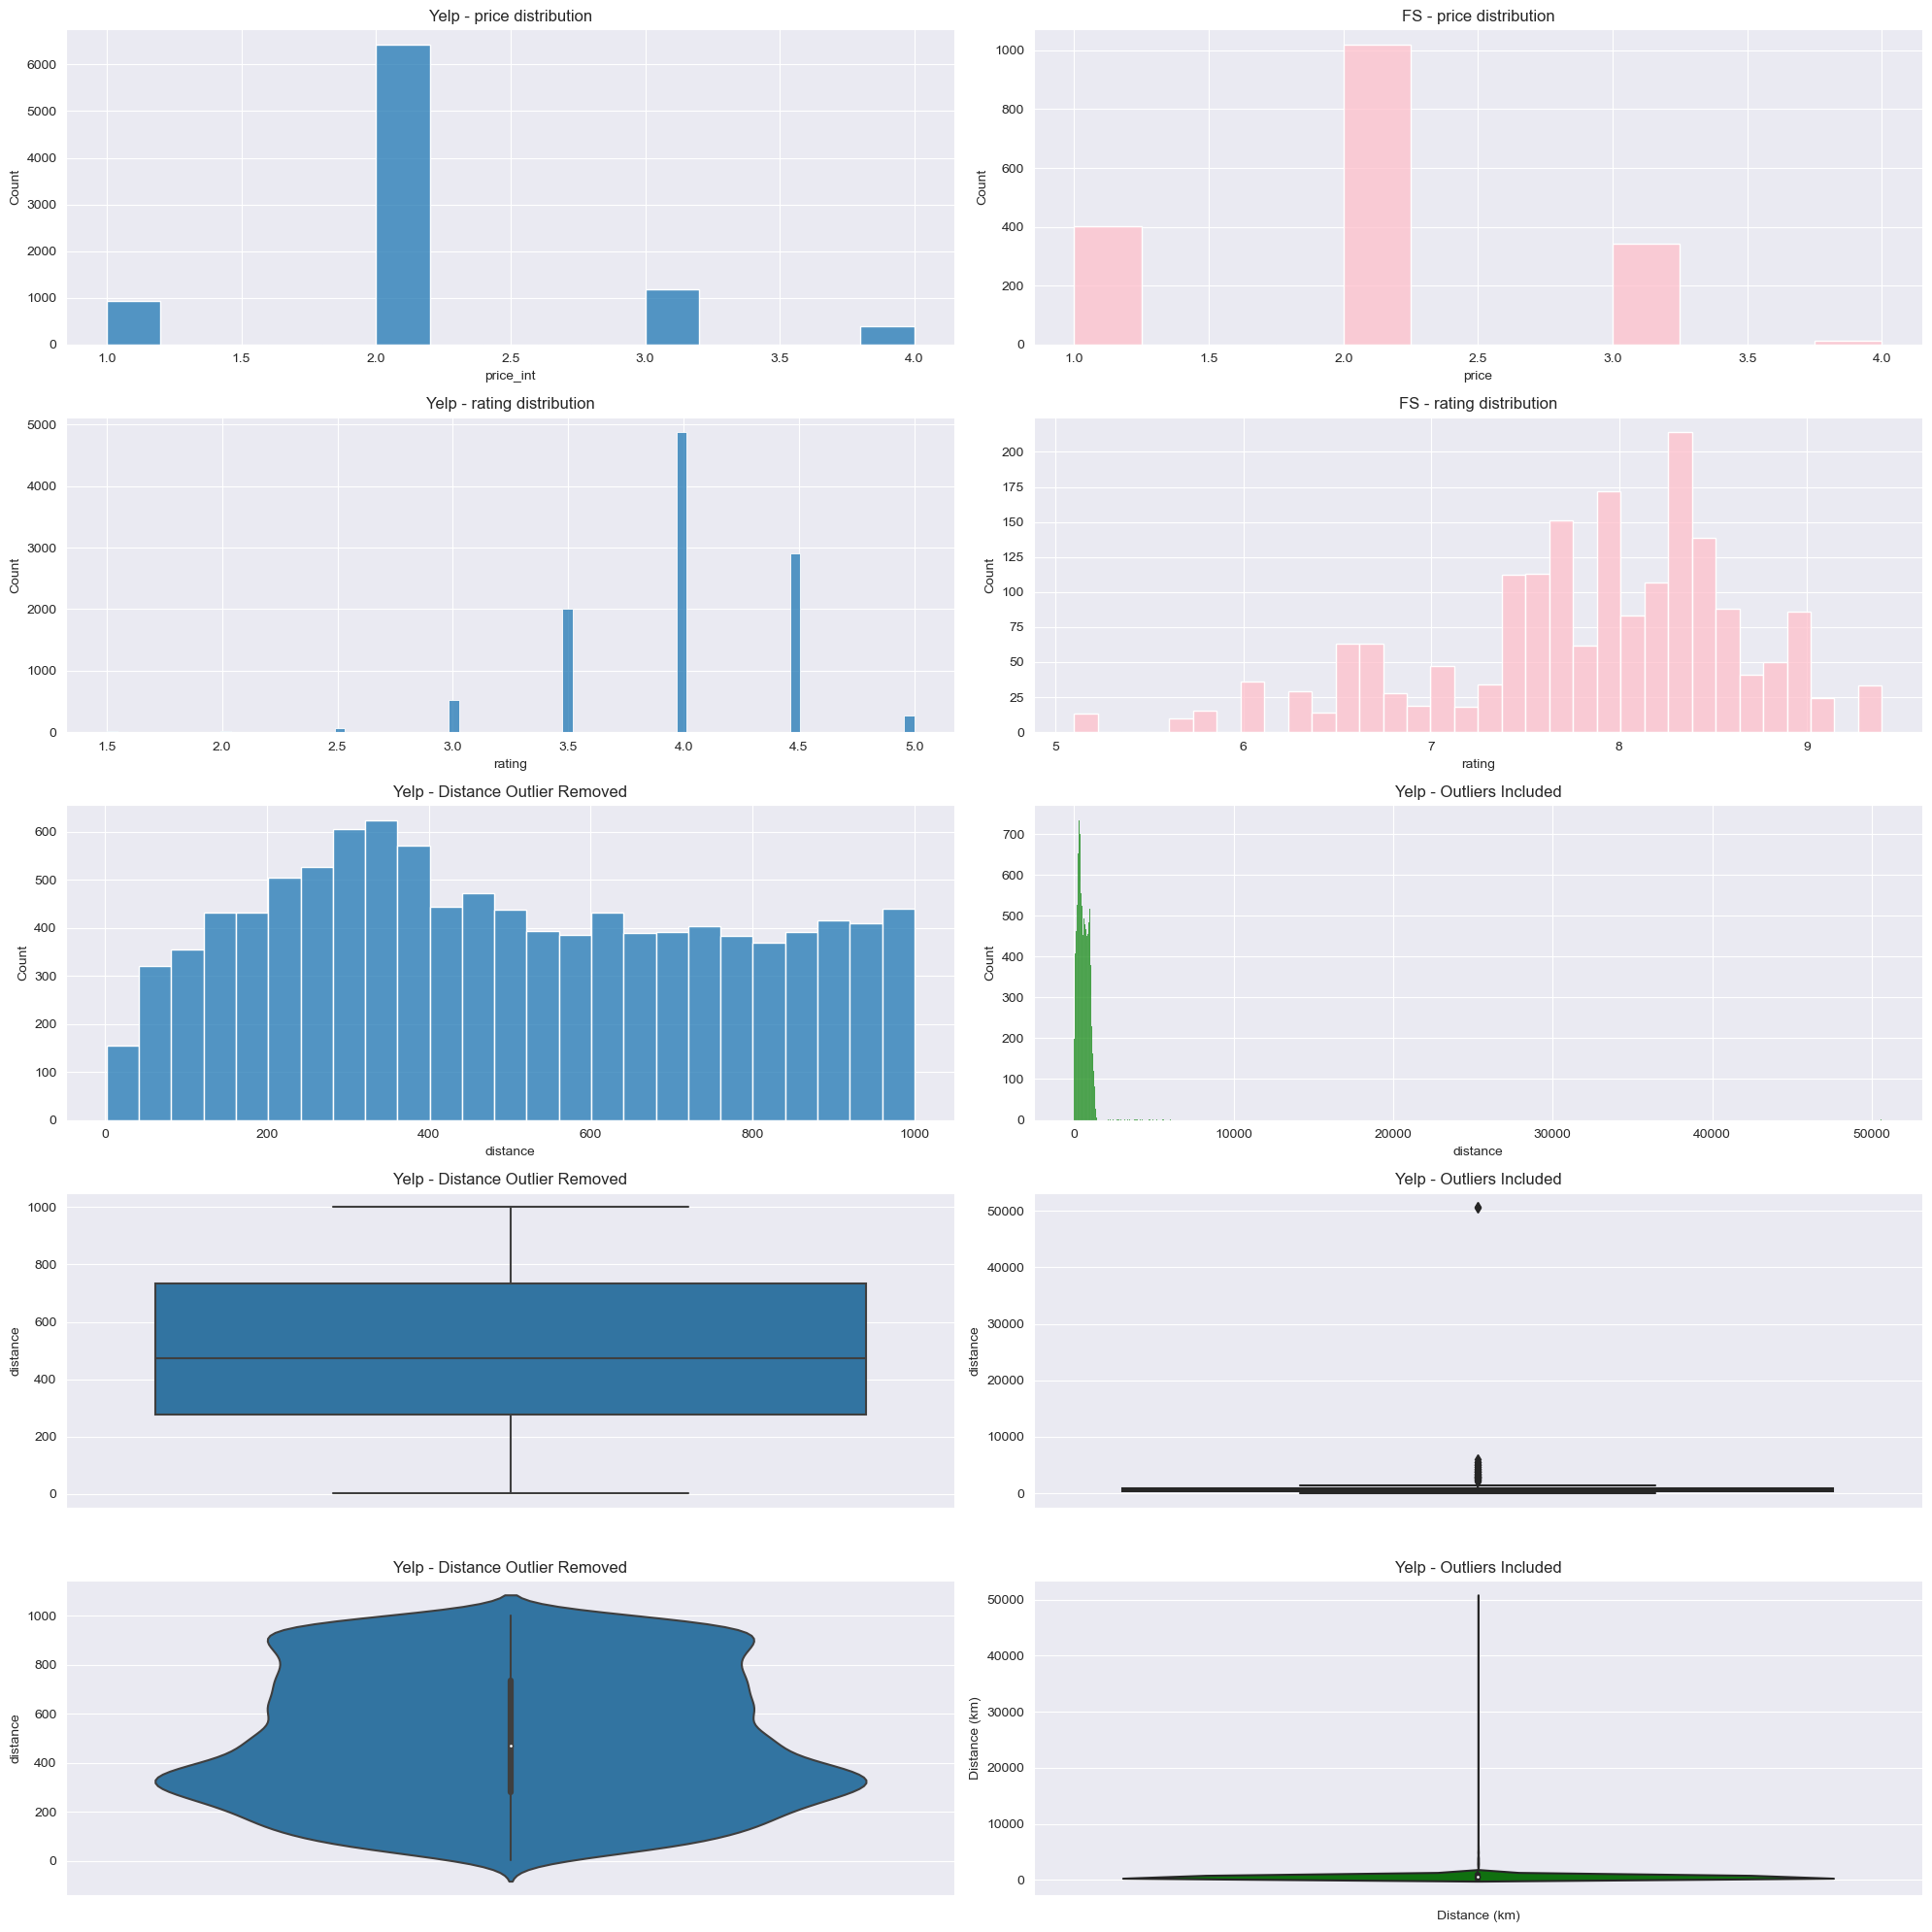

In [25]:
## Visualize Distribution of RATING, DISTANCE, PRICE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns

## Figure Layout and Aesthetic
fig, axes = plt.subplots(5,2, figsize=(20,20)) # 1 column, 2 row

## PRICE - HISTOGRAM
sns.histplot(YELP_df_clean_1km, x='price_int', ax=axes[0][0])
axes[0][0].set_title('Yelp - price distribution')

sns.histplot(FS_df, x='price', ax=axes[0][1], color='pink')
axes[0][1].set_title('FS - price distribution')

### RATING 
sns.histplot(YELP_df_clean_1km, x='rating', ax=axes[1][0])
axes[1][0].set_title('Yelp - rating distribution')

sns.histplot(FS_df, x='rating', ax=axes[1][1], color='pink')
axes[1][1].set_title('FS - rating distribution')

### Distace from Station
# 1. Histogram

sns.histplot(YELP_df_clean_1km, x='distance',ax=axes[2][0])  # `kde=True` will also plot a Kernel Density Estimate line
plt.title('Distribution of Distances from Bus Stop')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Places')
plt.xlim(0,1100)
axes[2][0].set_title('Yelp - Distance Outlier Removed')

sns.histplot(YELP_df_clean, x='distance',ax=axes[2][1], color='green')  # `kde=True` will also plot a Kernel Density Estimate line
plt.title('Distribution of Distances from Bus Stop')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Places')
plt.xlim(0,1100)
axes[2][1].set_title('Yelp - Outliers Included')
# 
# # 2. Boxplot
# 
sns.boxplot(y=YELP_df_clean_1km['distance'],ax=axes[3][0])
plt.title('Distances from Bus Stop')
plt.ylabel('Distance (km)')
axes[3][0].set_title('Yelp - Distance Outlier Removed')

sns.boxplot(y=YELP_df_clean['distance'],ax=axes[3][1], color='green')
plt.title('Distances from Bus Stop')
plt.ylabel('Distance (km)')
axes[3][1].set_title('Yelp - Outliers Included')

# 
# # 3. Violin Plot
# 
sns.violinplot(y=YELP_df_clean_1km['distance'],ax=axes[4][0])
plt.title('Violin Plot of Distances from Bus Stop')
plt.ylabel('Distance (km)')
# plt.ylim(0,1000)
axes[4][0].set_title('Yelp - Distance Outlier Removed')

sns.violinplot(y=YELP_df_clean['distance'],ax=axes[4][1], color='green')
plt.title('Violin Plot of Distances from Bus Stop')
plt.ylabel('Distance (km)')
# plt.ylim(0,1000)
# plt.xlim(-100,100)
axes[4][1].set_title('Yelp - Outliers Included')

plt.tight_layout()


## Interpretation= there are some outliers with the distance to the bike station!! How many are there?

In [ ]:
### Outlier (distance) count between FS and Yelp

Combined_Locations_in1km=Combined_Locations[(Combined_Locations['distance']<=1000) & (Combined_Locations['source']=='yelp')]
Combined_Locations_in1km

## Conclusion: 

For the purpose of this exercise, 'coverage' is defined as the count of POI (points of interest) of predefined categories that captured by the API. Coverage was initially evaluated by gross count of the POI (ie how many restaurants were identified). Additionally, a comparative analysis was performed for each restuarant name. 

Yelp API provided considerably more coverage on Vancouver-based restaurant and bars located within a 1km radius of city-share stations. 
Consequently, data gathered from the Foursquare API is not included in further modelling efforts. 